# 1. Data Handling and Processing


In [ ]:
import pandas as pd
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [ ]:
# Set random seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

# Load the dataset
data = pd.read_csv('phishing_email.csv')

# Display first few rows
print(data.head())

# Check for null values
print(data.isnull().sum())

# Basic statistics
print(data['label'].value_counts())

                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0
text_combined    0
label            0
dtype: int64
label
1    42891
0    39595
Name: count, dtype: int64


In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')

# Load NLTK stopwords and define the stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to clean text
def preprocess(text):
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Tokenize
    text = [word for word in text if word not in stop_words]  # Remove stop words
    text = [stemmer.stem(word) for word in text]  # Stemming
    return ' '.join(text)

# Apply preprocessing to the text data
data['text_combined'] = data['text_combined'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Library Imports: Import necessary libraries for data handling, model training, and evaluation.
Random Seed: Set a random seed for reproducibility of results.
Load Data: Read the CSV file into a DataFrame and display initial rows.
Data Inspection: Check for missing values and basic statistics.
Text Preprocessing: Clean and preprocess text data using NLTK (lowercasing, tokenization, stop word removal, and stemming).

# 2. Data Preparation


In [ ]:
# Define test size and random state
test_size = 0.2
random_state = 42

# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text_combined'],
    data['label'],
    test_size=test_size,
    random_state=random_state,
    stratify=data['label']  # Ensures proportional representation of classes
)


# 3. Tokenization and Encoding


In [ ]:
# Load TinyBERT tokenizer and model
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Model and tokenizer identifiers
# Each time change the PRETRAINED_MODEL_NAME
#PRETRAINED_MODEL_NAME = 'huawei-noah/TinyBERT_General_4L_312D'
PRETRAINED_MODEL_NAME = 'distilbert-base-uncased'

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
model_seq_classification = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=2)

#PRETRAINED_MODEL_NAME = 'google/tinybert-l4'
#tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
#model_seq_classification = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=2)

# Define maximum sequence length
MAX_LENGTH = 128

# Tokenize training data
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)

# Tokenize testing data
test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 4. Dataset Class


In [ ]:
# Define dataset class
class SpamDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.values  # Convert pandas Series to numpy array

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Create dataset instances
train_dataset = SpamDataset(train_encodings, train_labels)
test_dataset = SpamDataset(test_encodings, test_labels)


# 5. DataLoader and Training Setup


In [ ]:
# Define batch size and other training parameters
BATCH_SIZE = 16
EPOCHS = 7
ACCUMULATION_STEPS = 4  # Number of steps to accumulate gradients

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Define optimizer and scheduler
optimizer = optim.AdamW(model_seq_classification.parameters(), lr=2e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Define loss function
criterion = nn.CrossEntropyLoss()


# 6. Training and Evaluation


In [ ]:
# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_seq_classification.to(device)

# Initialize gradient scaler for mixed precision training
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

<ipython-input-8-540b6ea440dc>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Auto save

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Initialize lists to store loss values
train_losses = []
eval_losses = []

# Check if previous progress exists
if os.path.exists("training_progress_2.csv"):
    progress_df = pd.read_csv("training_progress_2.csv")
    train_losses = progress_df['train_loss'].tolist()
    eval_losses = progress_df['eval_loss'].tolist()
    start_epoch = len(train_losses)
else:
    start_epoch = 0

for epoch in range(start_epoch, EPOCHS):
    model_seq_classification.train()
    total_train_loss = 0
    train_preds = []
    train_labels_list = []

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)

    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model_seq_classification(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        scaler.scale(loss).backward()
        if (step + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1).flatten()
        train_preds.extend(preds.cpu().numpy())
        train_labels_list.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = accuracy_score(train_labels_list, train_preds)
    train_f1 = f1_score(train_labels_list, train_preds, average='weighted')

    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print(f'Training loss: {avg_train_loss:.4f}')
    print(f'Training accuracy: {train_accuracy:.4f}')
    print(f'Training F1 score: {train_f1:.4f}')

    # Evaluation after each epoch
    model_seq_classification.eval()
    total_eval_loss = 0
    eval_preds = []
    eval_labels_list = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating', leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with autocast():
                outputs = model_seq_classification(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

            total_eval_loss += loss.item()
            preds = torch.argmax(logits, dim=1).flatten()
            eval_preds.extend(preds.cpu().numpy())
            eval_labels_list.extend(labels.cpu().numpy())

    avg_eval_loss = total_eval_loss / len(test_loader)
    eval_losses.append(avg_eval_loss)
    eval_accuracy = accuracy_score(eval_labels_list, eval_preds)
    eval_f1 = f1_score(eval_labels_list, eval_preds, average='weighted')

    print(f'Validation loss: {avg_eval_loss:.4f}')
    print(f'Validation accuracy: {eval_accuracy:.4f}')
    print(f'Validation F1 score: {eval_f1:.4f}')
    print('-' * 50)

    # Save the current state of the model, optimizer, and scaler
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model_seq_classification.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'train_losses': train_losses,
        'eval_losses': eval_losses,
    }, f'checkpoint_epoch_{epoch+1}.pt')

    # Save the loss history to a CSV file
    progress_df = pd.DataFrame({
        'train_loss': train_losses,
        'eval_loss': eval_losses
    })
    progress_df.to_csv("training_progress_2.csv", index=False)

Epoch 1/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 1/7
Training loss: 0.1347
Training accuracy: 0.9479
Training F1 score: 0.9479


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Evaluating:   0%|          | 0/1032 [00:00<?, ?it/s]

Validation loss: 0.0589
Validation accuracy: 0.9779
Validation F1 score: 0.9779
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 2/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 2/7
Training loss: 0.0532
Training accuracy: 0.9817
Training F1 score: 0.9817


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Evaluating:   0%|          | 0/1032 [00:00<?, ?it/s]

Validation loss: 0.0493
Validation accuracy: 0.9823
Validation F1 score: 0.9823
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 3/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 3/7
Training loss: 0.0374
Training accuracy: 0.9874
Training F1 score: 0.9874


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Evaluating:   0%|          | 0/1032 [00:00<?, ?it/s]

Validation loss: 0.0374
Validation accuracy: 0.9868
Validation F1 score: 0.9868
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 4/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 4/7
Training loss: 0.0286
Training accuracy: 0.9905
Training F1 score: 0.9905


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Evaluating:   0%|          | 0/1032 [00:00<?, ?it/s]

Validation loss: 0.0344
Validation accuracy: 0.9894
Validation F1 score: 0.9894
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 5/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 5/7
Training loss: 0.0229
Training accuracy: 0.9930
Training F1 score: 0.9930


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Evaluating:   0%|          | 0/1032 [00:00<?, ?it/s]

Validation loss: 0.0337
Validation accuracy: 0.9895
Validation F1 score: 0.9895
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 6/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 6/7
Training loss: 0.0195
Training accuracy: 0.9936
Training F1 score: 0.9936


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Evaluating:   0%|          | 0/1032 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b2eae86dcf0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b2eae86dcf0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a

Validation loss: 0.0300
Validation accuracy: 0.9898
Validation F1 score: 0.9898
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 7/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 7/7
Training loss: 0.0150
Training accuracy: 0.9950
Training F1 score: 0.9950


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Evaluating:   0%|          | 0/1032 [00:00<?, ?it/s]

Validation loss: 0.0453
Validation accuracy: 0.9869
Validation F1 score: 0.9869
--------------------------------------------------


# Plots

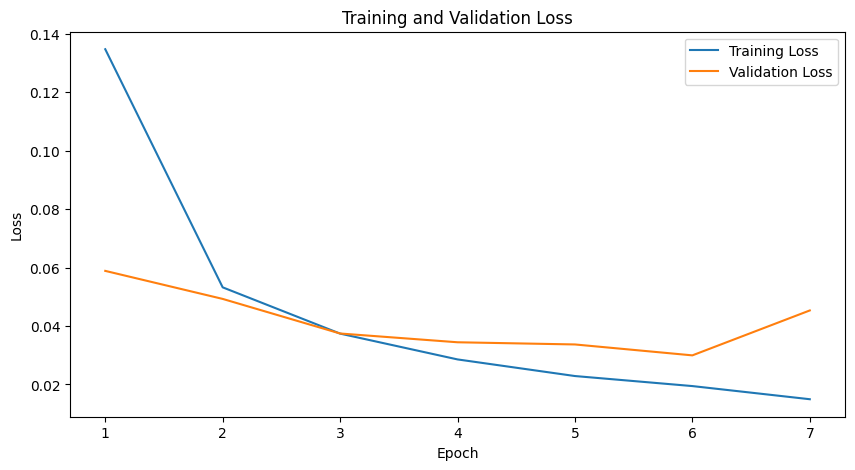

In [ ]:
# Plot training and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.98      1.00      0.99      7919
        Spam       1.00      0.98      0.99      8579

    accuracy                           0.99     16498
   macro avg       0.99      0.99      0.99     16498
weighted avg       0.99      0.99      0.99     16498



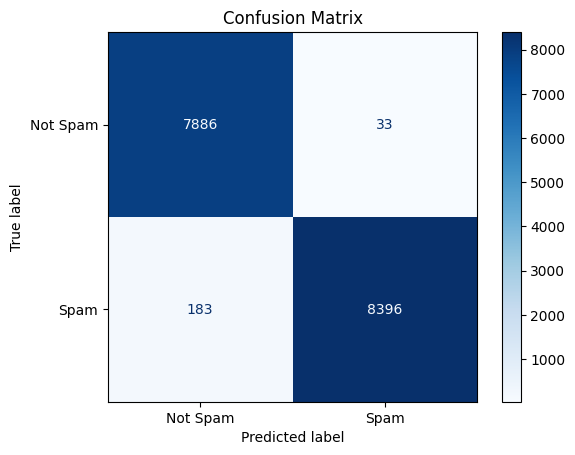

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Generate classification report
print("Classification Report:")
print(classification_report(eval_labels_list, eval_preds, target_names=['Not Spam', 'Spam']))

# Compute confusion matrix
cm = confusion_matrix(eval_labels_list, eval_preds, labels=[0, 1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the final model parameters after training is complete
torch.save(model_seq_classification.state_dict(), "distilbert.pth")
print("Model parameters saved to final_model.pth")

Model parameters saved to final_model.pth


# Model Compressing

we used 3 way to compress the model:

### Pruning

In [ ]:
import torch.nn.utils.prune as prune

def apply_pruning(model, pruning_amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=pruning_amount)
            prune.remove(module, 'weight')

In [ ]:
# Apply pruning to the model
apply_pruning(model_seq_classification, pruning_amount=0.3)

# Move the pruned model to the device (GPU/CPU)
model_seq_classification.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Training loop
for epoch in range(EPOCHS):
    model_seq_classification.train()
    total_train_loss = 0
    train_preds = []
    train_labels_list = []

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)

    for step, batch in enumerate(progress_bar):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model_seq_classification(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        scaler.scale(loss).backward()
        if (step + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        # Update tracking variables
        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1).flatten()
        train_preds.extend(preds.cpu().numpy())
        train_labels_list.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_labels_list, train_preds)
    train_f1 = f1_score(train_labels_list, train_preds, average='weighted')

    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print(f'Training loss: {avg_train_loss:.4f}')
    print(f'Training accuracy: {train_accuracy:.4f}')
    print(f'Training F1 score: {train_f1:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 1/7
Training loss: 0.0146
Training accuracy: 0.9953
Training F1 score: 0.9953


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 2/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 2/7
Training loss: 0.0109
Training accuracy: 0.9963
Training F1 score: 0.9963


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 3/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 3/7
Training loss: 0.0101
Training accuracy: 0.9966
Training F1 score: 0.9966


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 4/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 4/7
Training loss: 0.0084
Training accuracy: 0.9974
Training F1 score: 0.9974


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 5/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 5/7
Training loss: 0.0084
Training accuracy: 0.9973
Training F1 score: 0.9973


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 6/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 6/7
Training loss: 0.0050
Training accuracy: 0.9984
Training F1 score: 0.9984


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 7/7:   0%|          | 0/4125 [00:00<?, ?it/s]


Epoch 7/7
Training loss: 0.0041
Training accuracy: 0.9988
Training F1 score: 0.9988


In [ ]:
# Evaluation loop
model_seq_classification.eval()
total_eval_loss = 0
eval_preds = []
eval_labels_list = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with autocast():
            outputs = model_seq_classification(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()
        preds = torch.argmax(logits, dim=1).flatten()
        eval_preds.extend(preds.cpu().numpy())
        eval_labels_list.extend(labels.cpu().numpy())

    avg_eval_loss = total_eval_loss / len(test_loader)
    eval_accuracy = accuracy_score(eval_labels_list, eval_preds)
    eval_f1 = f1_score(eval_labels_list, eval_preds, average='weighted')

    print(f'Validation loss: {avg_eval_loss:.4f}')
    print(f'Validation accuracy: {eval_accuracy:.4f}')
    print(f'Validation F1 score: {eval_f1:.4f}')
    print('-' * 50)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Evaluating:   0%|          | 0/1032 [00:00<?, ?it/s]

Validation loss: 0.0278
Validation accuracy: 0.9930
Validation F1 score: 0.9930
--------------------------------------------------


In [ ]:
# Save the pruned model's state_dict
torch.save(model_seq_classification.state_dict(), 'pruned_model.pth')

### Knowledge distillation

In [ ]:
import torch
from transformers import DistilBertForSequenceClassification

# Load the DistilBERT model
distilbert_model_path = 'distilbert.pth'
student_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Load state_dict from file and map to CPU
#student_model.load_state_dict(torch.load(distilbert_model_path, map_location=torch.device('cpu')))

# Move model to the device (if you have GPU available, you can still move it)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
student_model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
from transformers import BertForSequenceClassification

# Load or define your teacher model
teacher_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
teacher_model.to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import torch.nn.functional as F

def distillation_loss(student_logits, teacher_logits, labels, temperature=2.0, alpha=0.5):
    # Compute the soft targets
    soft_targets = F.softmax(teacher_logits / temperature, dim=1)

    # Compute the distillation loss
    distill_loss = F.kl_div(F.log_softmax(student_logits / temperature, dim=1), soft_targets, reduction='batchmean')

    # Compute the classification loss
    class_loss = F.cross_entropy(student_logits, labels)

    # Combine losses
    return alpha * distill_loss + (1 - alpha) * class_loss

In [ ]:
import gc
import torch
from tqdm.auto import tqdm

EPOCHS = 1
CHECKPOINT_INTERVAL = 500  # Save every 1000 steps

# Function to save the checkpoint
def save_checkpoint(model, optimizer, epoch, step, loss, file_name="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, file_name)
    print(f"Checkpoint saved at epoch {epoch}, step {step}")

# Function to load the checkpoint
def load_checkpoint(model, optimizer, file_name="checkpoint.pth"):
    checkpoint = torch.load(file_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    start_step = checkpoint['step']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: epoch {start_epoch}, step {start_step}, loss {loss:.4f}")
    return start_epoch, start_step


In [ ]:
# Training loop
start_epoch = 0
start_step = 0

# Uncomment the following line if resuming from a checkpoint
# start_epoch, start_step = load_checkpoint(student_model, optimizer)

for epoch in range(start_epoch, EPOCHS):
    student_model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
    optimizer.zero_grad()

    for step, batch in enumerate(progress_bar, start=start_step):
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        # Forward pass with teacher model
        with torch.no_grad():
            teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
            teacher_logits = teacher_outputs.logits

        # Forward pass with student model
        student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        student_logits = student_outputs.logits
        loss = distillation_loss(student_logits, teacher_logits, labels)

        # Backward pass
        loss.backward()

        # Update the model parameters and reset gradients
        if (step + 1) % ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

        # Minimize memory footprint
        del input_ids, attention_mask, labels, teacher_outputs, teacher_logits, student_outputs, student_logits, loss
        gc.collect()

        # Save checkpoint periodically
        if (step + 1) % CHECKPOINT_INTERVAL == 0:
            save_checkpoint(student_model, optimizer, epoch, step, total_loss / (step + 1))

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}')
    save_checkpoint(student_model, optimizer, epoch, step, avg_loss)

    # Optionally clear cache and collect garbage if experiencing memory issues
    gc.collect()

# To resume, uncomment and adjust the load_checkpoint call as needed.


Epoch 1/1:   0%|          | 0/4125 [00:00<?, ?it/s]

Checkpoint saved at epoch 0, step 499


if it dissconnect:

In [ ]:
import gc
import torch
from tqdm.auto import tqdm

# Re-initialize the model, optimizer, and other components
# Assume `student_model` and `optimizer` are defined elsewhere
# and match the model and optimizer used in the saved checkpoint

# Load the checkpoint
start_epoch, start_step = load_checkpoint(student_model, optimizer, file_name="checkpoint.pth")

# Continue training from where it left off
for epoch in range(start_epoch, EPOCHS):
    student_model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
    optimizer.zero_grad()

    # Start from the step saved in the checkpoint
    for step, batch in enumerate(progress_bar, start=start_step):
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        # Forward pass with teacher model
        with torch.no_grad():
            teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
            teacher_logits = teacher_outputs.logits

        # Forward pass with student model
        student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        student_logits = student_outputs.logits
        loss = distillation_loss(student_logits, teacher_logits, labels)

        # Backward pass
        loss.backward()

        # Update the model parameters and reset gradients
        if (step + 1) % ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

        # Minimize memory footprint
        del input_ids, attention_mask, labels, teacher_outputs, teacher_logits, student_outputs, student_logits, loss
        gc.collect()

        # Save checkpoint periodically
        if (step + 1) % CHECKPOINT_INTERVAL == 0:
            save_checkpoint(student_model, optimizer, epoch, step, total_loss / (step + 1))

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}')
    save_checkpoint(student_model, optimizer, epoch, step, avg_loss)

    # Optionally clear cache and collect garbage if experiencing memory issues
    gc.collect()

    # Reset start_step for the next epoch
    start_step = 0


Checkpoint loaded: epoch 0, step 3499, loss 0.7556


<ipython-input-13-36b77378d711>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_name)


Epoch 1/1:   0%|          | 0/4125 [00:00<?, ?it/s]

Checkpoint saved at epoch 0, step 3499
Checkpoint saved at epoch 0, step 3999
Checkpoint saved at epoch 0, step 4499
Checkpoint saved at epoch 0, step 4999
Checkpoint saved at epoch 0, step 5499
Checkpoint saved at epoch 0, step 5999
Checkpoint saved at epoch 0, step 6499
Checkpoint saved at epoch 0, step 6999
Checkpoint saved at epoch 0, step 7499
Epoch 1/1 - Loss: 0.7548
Checkpoint saved at epoch 0, step 7623


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Set the student model to evaluation mode
student_model.eval()

# Initialize variables to track evaluation metrics
total_eval_loss = 0
eval_preds = []
eval_labels_list = []

# No gradient calculation needed during evaluation
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating', leave=False):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Get student's predictions
        outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss (you can use hard loss only during evaluation)
        loss = F.cross_entropy(logits, labels)
        total_eval_loss += loss.item()

        # Get predicted labels
        preds = torch.argmax(logits, dim=1).flatten()
        eval_preds.extend(preds.cpu().numpy())
        eval_labels_list.extend(labels.cpu().numpy())

# Calculate average loss and metrics
avg_eval_loss = total_eval_loss / len(test_loader)
eval_accuracy = accuracy_score(eval_labels_list, eval_preds)
eval_f1 = f1_score(eval_labels_list, eval_preds, average='weighted')

# Print the evaluation results
print(f'\nValidation loss: {avg_eval_loss:.4f}')
print(f'Validation accuracy: {eval_accuracy:.4f}')
print(f'Validation F1 score: {eval_f1:.4f}')
print('-' * 50)

Evaluating:   0%|          | 0/1032 [00:00<?, ?it/s]


Validation loss: 0.0453
Validation accuracy: 0.9869
Validation F1 score: 0.9869
--------------------------------------------------


In [ ]:
torch.save(student_model.state_dict(), 'distilled_student_model.pth')

### Quantization

Quantization is another technique for compressing models by reducing the precision of the numbers used to represent model parameters (weights) and activations. In PyTorch, quantization can be applied to a model either statically (before inference) or dynamically (during inference). Below is a step-by-step guide on how to apply dynamic quantization to a BERT model.

In [ ]:
from transformers import DistilBertForSequenceClassification
import torch

# Load the saved model on CPU
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.load_state_dict(torch.load('distilbert.pth', map_location=torch.device('cpu')))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-2405e23f0857>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by 

<All keys matched successfully>

In [ ]:
# Check if CUDA (GPU) is available and move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
import torch.quantization

# Set the model to training mode
model.train()

# Specify the quantization configuration
model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

# Prepare the model for quantization-aware training
torch.quantization.prepare_qat(model, inplace=False)


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:221: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(
        30522, 768, padding_idx=0
        (activation_post_process): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
          (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
        )
      )
      (position_embeddings): Embedding(
        512, 768
        (activation_post_process): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
          (activation_post_process): MovingAverageMinMaxObserve

In [ ]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
EPOCHS=1
# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    train_preds = []
    train_labels_list = []

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)

    for step, batch in enumerate(progress_bar):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()

        if (step + 1) % ACCUMULATION_STEPS == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        # Update tracking variables
        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1).flatten()
        train_preds.extend(preds.cpu().numpy())
        train_labels_list.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_labels_list, train_preds)
    train_f1 = f1_score(train_labels_list, train_preds, average='weighted')

    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print(f'Training loss: {avg_train_loss:.4f}')
    print(f'Training accuracy: {train_accuracy:.4f}')
    print(f'Training F1 score: {train_f1:.4f}')


Epoch 1/1
Training loss: 0.0442
Training accuracy: 0.9898
Training F1 score: 0.9898


In [ ]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.LayerNorm):
        module.qconfig = None  # Disable quantization for LayerNorm

In [ ]:
model.eval()
quantized_model = quant.convert(model, inplace=False)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
import torch

# Set the quantized model to evaluation mode
quantized_model.eval()

# Initialize variables to track evaluation metrics
eval_preds = []
eval_labels_list = []

# No gradient calculation needed during evaluation
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating', leave=False):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Get predictions from the quantized model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Accessing logits from the output

        # Get predicted labels
        preds = torch.argmax(logits, dim=1).flatten()
        eval_preds.extend(preds.cpu().numpy())
        eval_labels_list.extend(labels.cpu().numpy())

# Calculate metrics
eval_accuracy = accuracy_score(eval_labels_list, eval_preds)
eval_f1 = f1_score(eval_labels_list, eval_preds, average='weighted')

# Print the evaluation results
print(f'Validation accuracy: {eval_accuracy:.4f}')
print(f'Validation F1 score: {eval_f1:.4f}')
print('-' * 50)

Validation accuracy: 0.9796
Validation F1 score: 0.9796
--------------------------------------------------


In [ ]:
torch.save(quantized_model.state_dict(), 'distilbert_quantized_qat.pth')